# Noise2Self for Poisson Noise

This is a simple notebook demonstrating the principle of using self-supervision to train denoising networks, applied to PALM super-resolution microscopy data.

The characteristic feature of PALM is sparse Poisson sampling from a continuous structure.

The independence structure we exploit is the independence between individual fluorescence events.

We show that remarkable fidelity can be obtained from very few events, which without self-supervision would produce a very sparse rendition of the structure.

Here, we illustrate this for simulated data (Poisson noise on MNIST).

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from util import show, plot_images, plot_tensors

# Data

We demonstrate the use of a self-supervised denoising objective on a synthetically noised version of MNIST.

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Dataset

mnist_train = MNIST('data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                    ]), train = True)

mnist_test = MNIST('data/MNIST', download = True,
                    transform = transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                    ]), train = False)

In [5]:
import numpy as np
from torch import Tensor, nn

def sample(img, density):
    return Tensor(np.random.poisson(density*img.numpy()))

class PoissonNoiseDataset(Dataset):
    def __init__(self, data, density, scale_factor = None):
        self.data = data
        self.density = density
        
        self.scale_factor = scale_factor
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        
        if self.scale_factor:
            img = nn.functional.interpolate(img.unsqueeze(0), mode='bilinear', scale_factor=self.scale_factor)[0]
        
        return sample(img, self.density), sample(img, self.density), img*self.density

In [6]:
noisy_mnist_train = PoissonNoiseDataset(mnist_train, 0.05, 3)
noisy_mnist_test = PoissonNoiseDataset(mnist_test, 0.05, 3)

We will try to learn to predict the clean image on the right from the noisy image on the left.

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


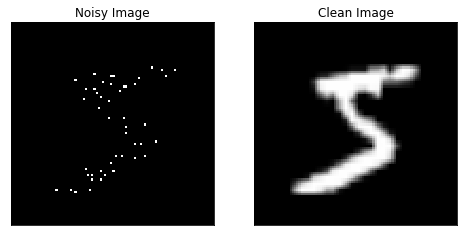

In [7]:
noisy1, noisy2, clean = noisy_mnist_train[0]
plot_tensors([noisy1[0], clean[0]], ['Noisy Image', 'Clean Image'])

# Invariance

The strategy is to train a $J$-invariant version of a neural net by splitting the Poisson samples into two groups, and trying to predict one from the other.

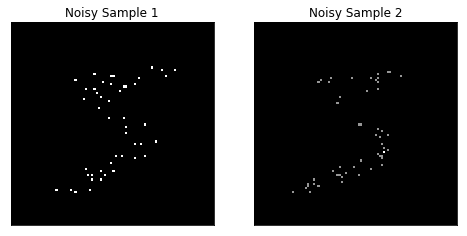

In [8]:
plot_tensors([noisy1[0], noisy2[0]],
            ["Noisy Sample 1", "Noisy Sample 2"])

# Model

In [11]:
device = 'cpu'

For our model, we use a short UNet with two levels of up- and down- sampling

In [12]:
from models.babyunet import BabyUnet
model = BabyUnet()

# Training

In [13]:
from torch.nn import MSELoss, PoissonNLLLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

loss_function = MSELoss()
mse = MSELoss()

loss_function = PoissonNLLLoss()

optimizer = Adam(model.parameters(), lr=0.001)

In [16]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=4,
                                              shuffle=False,
                                              num_workers=3)
i, val_batch = next(enumerate(test_data_loader))
noisy1_val, noisy2_val, clean_val = val_batch
noisy1_val, noisy2_val, clean_val = noisy1_val.to(device), noisy2_val.to(device), clean_val.to(device)

data_loader = DataLoader(noisy_mnist_train, batch_size=4, shuffle=True)

In [17]:
model = model.to(device)
model.train()

num_epochs = 1
for epoch in range(num_epochs):
    for i, batch in enumerate(data_loader):
        noisy_images1, noisy_images2, clean_images = batch

        net_input = noisy_images1.to(device)
        net_output = model(net_input)

        loss = loss_function(net_output, noisy_images2.to(device))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if i % 10 == 0:
            val_loss = loss_function(model(noisy1_val), noisy2_val).item()
            test_loss = mse(model(noisy1_val).exp(), clean_val).item()
            print("Loss (", i, "): ", np.round(loss.item(), 3), np.round(val_loss, 3), np.round(test_loss, 5))

Loss ( 0 ):  1.234 1.222 1.65168
Loss ( 10 ):  1.153 1.138 1.43349
Loss ( 20 ):  1.079 1.075 1.28154
Loss ( 30 ):  1.034 1.034 1.17942
Loss ( 40 ):  0.979 0.989 1.07721
Loss ( 50 ):  0.955 0.965 1.03614
Loss ( 60 ):  0.937 0.942 0.99629
Loss ( 70 ):  0.92 0.921 0.95659
Loss ( 80 ):  0.891 0.896 0.91603
Loss ( 90 ):  0.891 0.872 0.869
Loss ( 100 ):  0.839 0.847 0.81983
Loss ( 110 ):  0.808 0.816 0.76642
Loss ( 120 ):  0.766 0.781 0.69821
Loss ( 130 ):  0.735 0.744 0.62466
Loss ( 140 ):  0.688 0.706 0.5765
Loss ( 150 ):  0.671 0.68 0.53278
Loss ( 160 ):  0.626 0.649 0.49409
Loss ( 170 ):  0.622 0.619 0.45457
Loss ( 180 ):  0.577 0.591 0.42359
Loss ( 190 ):  0.556 0.566 0.38455
Loss ( 200 ):  0.528 0.54 0.357
Loss ( 210 ):  0.501 0.516 0.32177
Loss ( 220 ):  0.479 0.485 0.28811
Loss ( 230 ):  0.451 0.46 0.26072
Loss ( 240 ):  0.43 0.439 0.24228
Loss ( 250 ):  0.416 0.417 0.20467
Loss ( 260 ):  0.367 0.384 0.16305
Loss ( 270 ):  0.343 0.362 0.14451
Loss ( 280 ):  0.359 0.34 0.12741
Loss ( 

KeyboardInterrupt: 

The optimal validation loss would be:

In [32]:
round(loss_function((clean_val + 1e-5).log().to(device), noisy2_val.to(device)).item(), 3)

0.019

In [18]:
test_data_loader = DataLoader(noisy_mnist_test,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=3)
i, test_batch = next(enumerate(test_data_loader))
noisy1, noisy2, clean = test_batch

In [22]:
model.eval()
output = model(noisy1.to(device)).detach().cpu().exp()

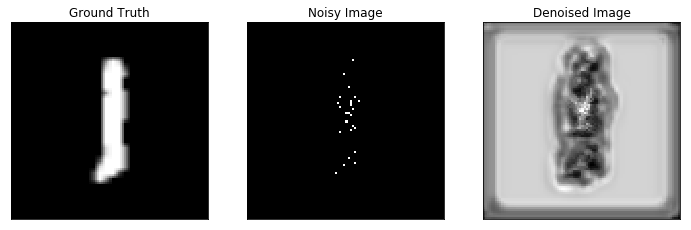

In [23]:
idx = 14
plot_tensors([clean[idx], noisy1[idx], output[idx]],
            ["Ground Truth", "Noisy Image", "Denoised Image"])